In [1]:
import tensorflow.keras
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from IPython import display

2024-04-15 00:29:26.815000: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 00:29:27.041842: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 00:29:28.276554: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
BINARY_SIZE = 1
PATCH_SIZE = 8
BATCH_SIZE = 256

In [3]:
def load_dataset(dataset_name):
    import keras.datasets as datasets
    (x_train, _), (x_test, _) = getattr(datasets, dataset_name).load_data()

    x_train = np.append(x_train, x_test, axis=0)
    x_train = x_train.astype('float32') / 255.
    return x_train

def get_data():
    cifar10_dataset = load_dataset('cifar10')
    cifar100_dataset = load_dataset('cifar100')
    # stl10_dataset = load_dataset('stl10')

    # append the datasets
    dataset = np.append(cifar10_dataset, cifar100_dataset, axis=0)
    # dataset = np.append(dataset,  axis=0)
    
    return dataset

def get_simple_data():
    cifar10_dataset = load_dataset('cifar10')

    return cifar10_dataset

In [4]:
dataset = get_simple_data()

In [5]:
dataset.shape

(60000, 32, 32, 3)

In [6]:
dataset = tf.image.extract_patches(dataset, sizes=[1, PATCH_SIZE, PATCH_SIZE, 1], strides=[1, PATCH_SIZE, PATCH_SIZE, 1], rates=[1, 1, 1, 1], padding='VALID')

2024-04-15 00:29:31.973062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 00:29:32.097383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 00:29:32.097505: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 00:29:32.102627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 00:29:32.102694: I tensorflow/compile

In [7]:
dataset = tf.reshape(dataset, [-1, PATCH_SIZE, PATCH_SIZE, 3])

In [8]:
# dataset to ycbcr
dataset = tf.image.rgb_to_yuv(dataset)

2024-04-15 00:29:34.331788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [9]:
train_dataset = dataset[:int(len(dataset) * 0.8)]
test_dataset = dataset[int(len(dataset) * 0.8):]

train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset).shuffle(int(len(train_dataset) * 0.8)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset).shuffle(int(len(test_dataset) * 0.8)).batch(BATCH_SIZE)

In [10]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(8, 8, 3)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=2*2*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(2, 2, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [11]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [12]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)


In [13]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [14]:
assert BATCH_SIZE >= num_examples_to_generate
test_batch = next(iter(test_dataset.take(1)))
test_sample = test_batch[0:num_examples_to_generate, :, :, :]

2024-04-15 00:29:34.801994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [192000,8,8,3]
	 [[{{node Placeholder/_0}}]]
2024-04-15 00:29:34.802230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [192000,8,8,3]
	 [[{{node Placeholder/_0}}]]


In [15]:
test_sample.shape

TensorShape([16, 8, 8, 3])

Epoch: 10, Test set ELBO: 5006595058565120.0


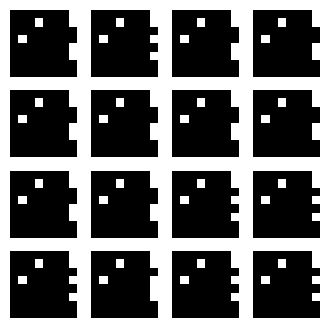

In [16]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}'
        .format(epoch, elbo))
  generate_and_save_images(model, epoch, test_sample)


In [17]:
def pad_image(image: np.ndarray, patch_size: int):
    h, w, c = image.shape
    h_pad = (patch_size - (h % patch_size)) % patch_size
    w_pad = (patch_size - (w % patch_size)) % patch_size

    return np.pad(image, ((0, h_pad), (0, w_pad), (0, 0)), mode='constant', constant_values=0), h_pad, w_pad

In [ ]:
def compress_image(image: np.ndarray, network: tf.keras.Model) -> tuple[np.ndarray, np.ndarray]:
    """
    Compress an image using the given network
    :param image: The image to compress
    :param network: The network to use for compression
    :return: The compressed image & the bits
    """
    patch_size = PATCH_SIZE

    # pad the image
    image, h_pad, w_pad = pad_image(image, patch_size)
    
    height, width, channels = image.shape
    no_patches_width = width // patch_size
    no_patches_height = height // patch_size
    
    # transform image to list with a single element
    image = tf.expand_dims(image, axis=0)

    image = tf.image.extract_patches(image, sizes=[1, patch_size, patch_size, 1], strides=[1, patch_size, patch_size, 1], rates=[1, 1, 1, 1], padding='VALID')
    image = tf.reshape(image, [-1, patch_size,patch_size,3])

    reconstructed_patches = []
    for i in range(len(image)):
        x = image[i]
        mean, logvar = model.encode(x)
        z = model.reparameterize(mean, logvar)
        x_logit = model.decode(z)
        reconstructed_patches.append(x_logit)
    reconstructed_image = np.zeros((height, width, channels))

    for i in range(no_patches_height):
        for j in range(no_patches_width):
            patch = reconstructed_patches[i*no_patches_width+j].reshape(patch_size, patch_size, 3)
            # print(i*patch_size, (i+1)*patch_size, j*patch_size, (j+1)*patch_size)
            reconstructed_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patch

    height = height - h_pad
    width = width - w_pad

    reconstructed_image = reconstructed_image[:height, :width]

    # convert reconstructed image to tensor
    reconstructed_image = tf.convert_to_tensor(reconstructed_image)
    reconstructed_image = tf.image.yuv_to_rgb(reconstructed_image) * 255

    return reconstructed_image

In [20]:
image = tf.image.decode_image(tf.io.read_file('ciob.png'), channels=3, dtype='float32')

image = image
image = tf.image.rgb_to_yuv(image)

reconstructed_image_32 = compress_image(image, model)
reconstructed_image_32 = tf.cast(reconstructed_image_32, tf.uint8)
# reconstructed_image_32 = reconstructed_image_32 * 255

image = tf.image.yuv_to_rgb(image)
image = tf.cast(image * 255, tf.uint8)

NotImplementedError: in user code:

    File "/home/cezar/anaconda3/envs/disertatie/lib/python3.11/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/home/cezar/anaconda3/envs/disertatie/lib/python3.11/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/cezar/anaconda3/envs/disertatie/lib/python3.11/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/home/cezar/anaconda3/envs/disertatie/lib/python3.11/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/home/cezar/anaconda3/envs/disertatie/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/cezar/anaconda3/envs/disertatie/lib/python3.11/site-packages/keras/engine/training.py", line 585, in call
        raise NotImplementedError(

    NotImplementedError: Exception encountered when calling layer 'cvae' (type CVAE).
    
    Unimplemented `tf.keras.Model.call()`: if you intend to create a `Model` with the Functional API, please provide `inputs` and `outputs` arguments. Otherwise, subclass `Model` with an overridden `call()` method.
    
    Call arguments received by layer 'cvae' (type CVAE):
      • inputs=tf.Tensor(shape=(None, 8, 8, 3), dtype=float32)
      • training=False
      • mask=None


In [ ]:
import matplotlib.pyplot as plt

ax, fig = plt.subplots(1, 2)
fig[0].imshow(image)
fig[1].imshow(reconstructed_image_32)

: 

In [ ]:
# compute psnr
tf.image.psnr(image, reconstructed_image_32, max_val=255)

: 

In [ ]:
tf.image.ssim(image, reconstructed_image_32, max_val=255)

: 

In [ ]:
tf.image.ssim_multiscale(image, reconstructed_image_32, max_val=255)

: 

In [ ]:
encoder = tensorflow.keras.Model(image_input, encoded)

: 

In [ ]:
image = tf.image.decode_image(tf.io.read_file('ciob.png'), channels=3, dtype='float32')
image = tf.image.rgb_to_yuv(image)

image_, _, _ = pad_image(image, PATCH_SIZE)

no_patches_width = image_.shape[1] // PATCH_SIZE
no_patches_height = image_.shape[0] // PATCH_SIZE

width = image_.shape[1]
height = image_.shape[0]

image_ = tf.expand_dims(image_, axis=0)
img_patches = tf.image.extract_patches(image_, sizes=[1, PATCH_SIZE, PATCH_SIZE, 1], strides=[1, PATCH_SIZE, PATCH_SIZE, 1], rates=[1, 1, 1, 1], padding='VALID')
img_patches = tf.reshape(img_patches, [-1, PATCH_SIZE, PATCH_SIZE, 3])

encoded_patches = encoder.predict(img_patches)

: 

In [ ]:
encoded_patches = encoded_patches.astype(np.float16)
copy_encoded_patches = encoded_patches.copy()

: 

In [ ]:
# keep only the first 4 decimals
encoded_patches = np.around(encoded_patches, 4)

: 

In [ ]:
decoder_input = tensorflow.keras.layers.Input(shape=(1, 1, 8))
decoder = tensorflow.keras.Model(encoded, decoded)

rec = decoder.predict(encoded_patches)

: 

In [ ]:
reconstructed_image_16 = np.zeros((height, width, 3))

for i in range(no_patches_height):
    for j in range(no_patches_width):
        patch = rec[i*no_patches_width+j].reshape(PATCH_SIZE, PATCH_SIZE, 3)
        reconstructed_image_16[i*PATCH_SIZE:(i+1)*PATCH_SIZE, j*PATCH_SIZE:(j+1)*PATCH_SIZE] = patch

reconstructed_image_16 = reconstructed_image_16[:image.shape[0], :image.shape[1]]
reconstructed_image_16 = tf.convert_to_tensor(reconstructed_image_16)
reconstructed_image_16 = tf.image.yuv_to_rgb(reconstructed_image_16) * 255
reconstructed_image_16 = tf.cast(reconstructed_image_16, tf.uint8)

image = tf.image.yuv_to_rgb(image)
image = tf.cast(image * 255, tf.uint8)

: 

In [ ]:
import matplotlib.pyplot as plt

ax, fig = plt.subplots(1, 2)
fig[0].imshow(image)
fig[1].imshow(reconstructed_image_16)

: 

In [ ]:
tf.image.psnr(image, reconstructed_image_16, max_val=255)

: 

In [ ]:
tf.image.ssim(image, reconstructed_image_16, max_val=255)

: 

In [ ]:
tf.image.ssim_multiscale(image, reconstructed_image_16, max_val=255)

: 

In [ ]:
encoded_patches.shape

: 